In [1]:
import torch
from openai import OpenAI
from tqdm import tqdm
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Read the Combined Evaluation Responses along with Question/Answer Pairs for Validation Dataset

In [2]:
with open('response_generation_data/all_model_responses.pkl', 'rb') as file:
    all_model_responses = pickle.load(file)

all_model_responses.head()

,topic,question,answerText,gpt_responses_base,gpt_responses_ft,llama_responses_base,llama_responses_ft
0,relationships,I had to go to the emergency room today to get...,It is extremely frustrating when our significa...,I'm sorry to hear about your experience. It's ...,Be straightforward with how you felt at that s...,It's completely understandable that you're fee...,It's hard to understand why you're mad. It's p...
1,marriage,What makes a healthy marriage last? What makes...,"This is a fantastic question. In one sentence,...",A healthy and lasting marriage often hinges on...,"What a happy, healthy marriage looks or feels ...",A healthy marriage is built on a foundation of...,Good question! There are many things that can ...
2,relationships,"I'm a female freshman in high school, and this...","First off, I think it is great that you are wi...",It's great that you want to support your frien...,Hi there. It sounds like you care a lot for Ti...,I'm glad you're taking the initiative to suppo...,"Hi. You're asking a lot of questions, and I'll..."
3,intimacy,"My wife and I are newly married, about 2 month...","You are newly married, you Have a hectic sched...",Navigating intimacy issues in a new marriage c...,You have most of the knowledge you need alread...,I can sense the frustration and concern in you...,I think you're being overly critical of your w...
4,legal-regulatory,"I think I have depression, anxiety, bipolar di...",It can be difficult to get counseling if you d...,I'm sorry to hear you're going through this. I...,There are a number of resources you can utiliz...,I'm so sorry to hear that you're struggling wi...,I'm so sorry to hear that you are struggling w...


#### Creating a new dataframe to record the evaluation results

Calculating the word length of the response of each model

In [6]:
df_response_evaluation = pd.DataFrame(all_model_responses['topic'])

In [7]:
df_response_evaluation['gpt_responses_base_len'] = all_model_responses['gpt_responses_base'].apply(lambda x: len(x.split()))
df_response_evaluation['gpt_responses_ft_len'] = all_model_responses['gpt_responses_ft'].apply(lambda x: len(x.split()))
df_response_evaluation['llama_responses_base_len'] = all_model_responses['llama_responses_base'].apply(lambda x: len(x.split()))
df_response_evaluation['llama_responses_ft_len'] = all_model_responses['llama_responses_ft'].apply(lambda x: len(x.split()))
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len
0,relationships,186,175,197,189
1,marriage,211,282,225,67
2,relationships,209,204,333,217
3,intimacy,203,229,325,206
4,legal-regulatory,192,159,207,162


### OpenAI Configuration and Responses

In [8]:
with open("../../api.key", 'r') as file:
    openai_api_key = file.read()

openai_client = OpenAI(api_key=openai_api_key)

In [9]:
def get_openai_response(system_prompt: str, user_prompt: str) -> str:
        
    completion = openai_client.chat.completions.create(
    model="gpt-4o",
    temperature=0,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
        ]
    )

    openai_response = completion.choices[0].message.content
    
    return openai_response

### Evaluating the responses by GPT based on CTRS Metrics

In [10]:
system_prompt_eval = 'You are an expert mental-health counsellor'
user_prompt_eval = '''You are given a conversation between a patient and therapist. Your job is to evaluate the response of therapist against the problem described by the patient as per the criterion of
Understanding, Interpersonal Effectiveness, Collaboration, Guided Discovery, Focus and Strategy. The definition for each of these criterion is mentioned below:

Understanding: How accurately does the therapist demonstrate understanding of the client’s issues and concerns?
Interpersonal Effectiveness: How effective is the therapist in maintaining a positive and therapeutic relationship with the client?
Collaboration: To what extent does the therapist engage the client in collaborative goalsetting and decision-making?
Guided Discovery: How effectively does the therapist use guided discovery techniques to facilitate client self-reflection and insight?
Focus: How well does the therapist identify and address the client’s key cognitions or behaviors that need change?
Strategy: How appropriate and coherent is the therapist’s strategy for promoting change in the client’s problematic behaviors or thoughts?

For each of these criterion, you need to assign a rating of 0 to 6 based on how well the therapist response fulfills the definition of the specific criterion.

You final response must not contain any description about any criterion and it must ONLY be in a json serializable format as following {{
    Understanding: understanding_rating,
    Interpersonal Effectiveness: interpersonal_effectiveness_rating,
    Collaboration: collaboration_rating,
    Guided Discovery: guided_discovery_rating,
    Focus: focus_rating,
    Strategy: strategy_rating,
}}

[PATIENT Problem]:
{patient}

[THERAPIST Response]:
{therapist}
'''

#### Evaluating the Original Responses

In [11]:
# original_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['answerText'] #Original Response
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     original_responses_eval.append(response_eval)

# with open('response_evaluation_data/original_responses_eval.pkl', 'wb') as file:
#     pickle.dump(original_responses_eval, file)

In [12]:
with open('response_evaluation_data/original_responses_eval.pkl', 'rb') as file:
    original_responses_eval = pickle.load(file)

In [13]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(original_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)


In [14]:
df_response_evaluation['undr_orig'] = understanding
df_response_evaluation['inter_pers_orig'] = interpersonal_effectiveness
df_response_evaluation['colab_orig'] = collaboration
df_response_evaluation['guid_disc_orig'] = guided_discovery
df_response_evaluation['foc_orig'] = focus
df_response_evaluation['strat_orig'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,strat_orig
0,relationships,186,175,197,189,5,5,5,3,4,4
1,marriage,211,282,225,67,5,5,5,4,4,4
2,relationships,209,204,333,217,5,5,5,3,4,4
3,intimacy,203,229,325,206,4,5,5,2,4,4
4,legal-regulatory,192,159,207,162,4,5,5,2,3,4


#### Evaluating the LLaMA Base Responses

In [ ]:
# llama_base_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['llama_responses_base'] #LLaMA Response Base
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     llama_base_responses_eval.append(response_eval)

# with open('response_evaluation_data/llama_base_responses_eval.pkl', 'wb') as file:
#     pickle.dump(llama_base_responses_eval, file)

In [16]:
with open('response_evaluation_data/llama_base_responses_eval.pkl', 'rb') as file:
    llama_base_responses_eval = pickle.load(file)

In [17]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(llama_base_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

13
90


In [18]:
df_response_evaluation['undr_llama_base'] = understanding
df_response_evaluation['inter_pers_llama_base'] = interpersonal_effectiveness
df_response_evaluation['colab_llama_base'] = collaboration
df_response_evaluation['guid_disc_llama_base'] = guided_discovery
df_response_evaluation['foc_llama_base'] = focus
df_response_evaluation['strat_llama_base'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,strat_orig,undr_llama_base,inter_pers_llama_base,colab_llama_base,guid_disc_llama_base,foc_llama_base,strat_llama_base
0,relationships,186,175,197,189,5,5,5,3,4,4,5.0,5.0,5.0,3.0,4.0,5.0
1,marriage,211,282,225,67,5,5,5,4,4,4,4.0,5.0,5.0,1.0,3.0,3.0
2,relationships,209,204,333,217,5,5,5,3,4,4,5.0,5.0,5.0,4.0,5.0,5.0
3,intimacy,203,229,325,206,4,5,5,2,4,4,5.0,5.0,5.0,3.0,4.0,4.0
4,legal-regulatory,192,159,207,162,4,5,5,2,3,4,5.0,5.0,5.0,2.0,4.0,5.0


#### Evaluating the LLaMA Finetuned Responses

In [ ]:
# llama_ft_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['llama_responses_ft'] #LLaMA Responses Finetuned
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     llama_ft_responses_eval.append(response_eval)

# with open('response_evaluation_data/llama_ft_responses_eval.pkl', 'wb') as file:
#     pickle.dump(llama_ft_responses_eval, file)

In [19]:
with open('response_evaluation_data/llama_ft_responses_eval.pkl', 'rb') as file:
    llama_ft_responses_eval = pickle.load(file)

In [20]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(llama_ft_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [21]:
df_response_evaluation['undr_llama_ft'] = understanding
df_response_evaluation['inter_pers_llama_ft'] = interpersonal_effectiveness
df_response_evaluation['colab_llama_ft'] = collaboration
df_response_evaluation['guid_disc_llama_ft'] = guided_discovery
df_response_evaluation['foc_llama_ft'] = focus
df_response_evaluation['strat_llama_ft'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,...,colab_llama_base,guid_disc_llama_base,foc_llama_base,strat_llama_base,undr_llama_ft,inter_pers_llama_ft,colab_llama_ft,guid_disc_llama_ft,foc_llama_ft,strat_llama_ft
0,relationships,186,175,197,189,5,5,5,3,4,...,5.0,3.0,4.0,5.0,4,3,3,3,3,3
1,marriage,211,282,225,67,5,5,5,4,4,...,5.0,1.0,3.0,3.0,4,5,5,2,3,3
2,relationships,209,204,333,217,5,5,5,3,4,...,5.0,4.0,5.0,5.0,2,2,2,1,1,1
3,intimacy,203,229,325,206,4,5,5,2,4,...,5.0,3.0,4.0,4.0,3,2,2,1,2,2
4,legal-regulatory,192,159,207,162,4,5,5,2,3,...,5.0,2.0,4.0,5.0,4,4,4,2,3,3


#### Evaluating the Base GPT Reponses

In [22]:
# gpt_base_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['gpt_responses_base'] #GPT Response Base
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     gpt_base_responses_eval.append(response_eval)

# with open('response_evaluation_data/gpt_base_responses_eval.pkl', 'wb') as file:
#     pickle.dump(gpt_base_responses_eval, file)

In [23]:
with open('response_evaluation_data/gpt_base_responses_eval.pkl', 'rb') as file:
    gpt_base_responses_eval = pickle.load(file)

In [24]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(gpt_base_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [25]:
df_response_evaluation['undr_gpt_base'] = understanding
df_response_evaluation['inter_pers_gpt_base'] = interpersonal_effectiveness
df_response_evaluation['colab_gpt_base'] = collaboration
df_response_evaluation['guid_disc_gpt_base'] = guided_discovery
df_response_evaluation['foc_gpt_base'] = focus
df_response_evaluation['strat_gpt_base'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,...,colab_llama_ft,guid_disc_llama_ft,foc_llama_ft,strat_llama_ft,undr_gpt_base,inter_pers_gpt_base,colab_gpt_base,guid_disc_gpt_base,foc_gpt_base,strat_gpt_base
0,relationships,186,175,197,189,5,5,5,3,4,...,3,3,3,3,5,5,5,3,4,5
1,marriage,211,282,225,67,5,5,5,4,4,...,5,2,3,3,3,4,4,1,3,2
2,relationships,209,204,333,217,5,5,5,3,4,...,2,1,1,1,5,5,5,2,4,4
3,intimacy,203,229,325,206,4,5,5,2,4,...,2,1,2,2,5,5,5,3,4,5
4,legal-regulatory,192,159,207,162,4,5,5,2,3,...,4,2,3,3,5,5,5,3,4,5


#### Evaluating the GPT Fine-Tuned Responses

In [26]:
# gpt_ft_responses_eval = []

# for index, row in tqdm(all_model_responses.iterrows(), total=len(all_model_responses)):
    
#     patient_problem = row['question']
#     therapist_response = row['gpt_responses_ft'] #GPT Response Finetuned
    
#     response_eval = get_openai_response(system_prompt=system_prompt_eval, user_prompt=user_prompt_eval.format(patient=patient_problem, therapist=therapist_response))
    
#     gpt_ft_responses_eval.append(response_eval)

# with open('response_evaluation_data/gpt_ft_responses_eval.pkl', 'wb') as file:
#     pickle.dump(gpt_ft_responses_eval, file)

In [27]:
with open('response_evaluation_data/gpt_ft_responses_eval.pkl', 'rb') as file:
    gpt_ft_responses_eval = pickle.load(file)

In [28]:
understanding = []
interpersonal_effectiveness  = []
collaboration = []
guided_discovery = []
focus = []
strategy = []

for index, response in enumerate(gpt_ft_responses_eval):
    response = response.replace('json','').replace("```",'')
    try:
        json_response = json.loads(response)
        understanding.append(json_response['Understanding'])
        interpersonal_effectiveness.append(json_response['Interpersonal Effectiveness'])
        collaboration.append(json_response['Interpersonal Effectiveness'])
        guided_discovery.append(json_response['Guided Discovery'])
        focus.append(json_response['Focus'])
        strategy.append(json_response['Strategy'])
    except:
        print(index)
        understanding.append(None)
        interpersonal_effectiveness.append(None)
        collaboration.append(None)
        guided_discovery.append(None)
        focus.append(None)
        strategy.append(None)

In [29]:
df_response_evaluation['undr_gpt_ft'] = understanding
df_response_evaluation['inter_pers_gpt_ft'] = interpersonal_effectiveness
df_response_evaluation['colab_gpt_ft'] = collaboration
df_response_evaluation['guid_disc_gpt_ft'] = guided_discovery
df_response_evaluation['foc_gpt_ft'] = focus
df_response_evaluation['strat_gpt_ft'] = strategy
df_response_evaluation.head()

,topic,gpt_responses_base_len,gpt_responses_ft_len,llama_responses_base_len,llama_responses_ft_len,undr_orig,inter_pers_orig,colab_orig,guid_disc_orig,foc_orig,...,colab_gpt_base,guid_disc_gpt_base,foc_gpt_base,strat_gpt_base,undr_gpt_ft,inter_pers_gpt_ft,colab_gpt_ft,guid_disc_gpt_ft,foc_gpt_ft,strat_gpt_ft
0,relationships,186,175,197,189,5,5,5,3,4,...,5,3,4,5,5,5,5,4,4,4
1,marriage,211,282,225,67,5,5,5,4,4,...,4,1,3,2,5,5,5,4,4,4
2,relationships,209,204,333,217,5,5,5,3,4,...,5,2,4,4,5,5,5,3,4,4
3,intimacy,203,229,325,206,4,5,5,2,4,...,5,3,4,5,5,5,5,4,4,4
4,legal-regulatory,192,159,207,162,4,5,5,2,3,...,5,3,4,5,4,4,4,2,3,4


### Creating comparisons of evaluation between different answers

In [30]:
viz_df = df_response_evaluation[['topic','undr_orig', 'undr_llama_ft', 'undr_llama_base', 'undr_gpt_base', 'undr_gpt_ft',
                                'inter_pers_orig', 'inter_pers_llama_ft', 'inter_pers_llama_base', 'inter_pers_gpt_base', 'inter_pers_gpt_ft',
                                'colab_orig', 'colab_llama_ft', 'colab_llama_base', 'colab_gpt_base', 'colab_gpt_ft',
                                'guid_disc_orig', 'guid_disc_llama_ft', 'guid_disc_llama_base', 'guid_disc_gpt_base', 'guid_disc_gpt_ft',
                                'foc_orig', 'foc_llama_ft', 'foc_llama_base', 'foc_gpt_base', 'foc_gpt_ft',
                                'strat_orig', 'strat_llama_ft', 'strat_llama_base', 'strat_gpt_base', 'strat_gpt_ft']].set_index('topic')

viz_df

,undr_orig,undr_llama_ft,undr_llama_base,undr_gpt_base,undr_gpt_ft,inter_pers_orig,inter_pers_llama_ft,inter_pers_llama_base,inter_pers_gpt_base,inter_pers_gpt_ft,...,foc_orig,foc_llama_ft,foc_llama_base,foc_gpt_base,foc_gpt_ft,strat_orig,strat_llama_ft,strat_llama_base,strat_gpt_base,strat_gpt_ft
topic,,,,,,,,,,,,,,,,,,,,,
relationships,5,4,5.0,5,5,5,3,5.0,5,5,...,4,3,4.0,4,4,4,3,5.0,5,4
marriage,5,4,4.0,3,5,5,5,5.0,4,5,...,4,3,3.0,3,4,4,3,3.0,2,4
relationships,5,2,5.0,5,5,5,2,5.0,5,5,...,4,1,5.0,4,4,4,1,5.0,4,4
intimacy,4,3,5.0,5,5,5,2,5.0,5,5,...,4,2,4.0,4,4,4,2,4.0,5,4
legal-regulatory,4,4,5.0,5,4,5,4,5.0,5,4,...,3,3,4.0,4,3,4,3,5.0,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
depression,4,0,0.0,5,4,3,0,0.0,5,4,...,3,0,0.0,4,3,3,0,0.0,4,3
parenting,3,0,0.0,5,5,2,0,0.0,5,5,...,3,0,0.0,4,4,2,0,0.0,5,4
counseling-fundamentals,4,1,2.0,5,4,5,1,3.0,5,5,...,3,0,2.0,4,4,3,0,2.0,5,4


In [31]:
avg_metrics = viz_df.agg('mean')
avg_metrics

undr_orig                4.104046
undr_llama_ft            1.335260
undr_llama_base          3.216374
undr_gpt_base            4.976879
undr_gpt_ft              3.895954
inter_pers_orig          4.144509
inter_pers_llama_ft      1.381503
inter_pers_llama_base    3.298246
inter_pers_gpt_base      5.005780
inter_pers_gpt_ft        3.786127
colab_orig               4.144509
colab_llama_ft           1.381503
colab_llama_base         3.298246
colab_gpt_base           5.005780
colab_gpt_ft             3.786127
guid_disc_orig           2.670520
guid_disc_llama_ft       0.630058
guid_disc_llama_base     1.801170
guid_disc_gpt_base       3.092486
guid_disc_gpt_ft         2.549133
foc_orig                 3.289017
foc_llama_ft             0.907514
foc_llama_base           2.578947
foc_gpt_base             4.179191
foc_gpt_ft               2.936416
strat_orig               3.236994
strat_llama_ft           0.832370
strat_llama_base         2.666667
strat_gpt_base           4.653179
strat_gpt_ft  

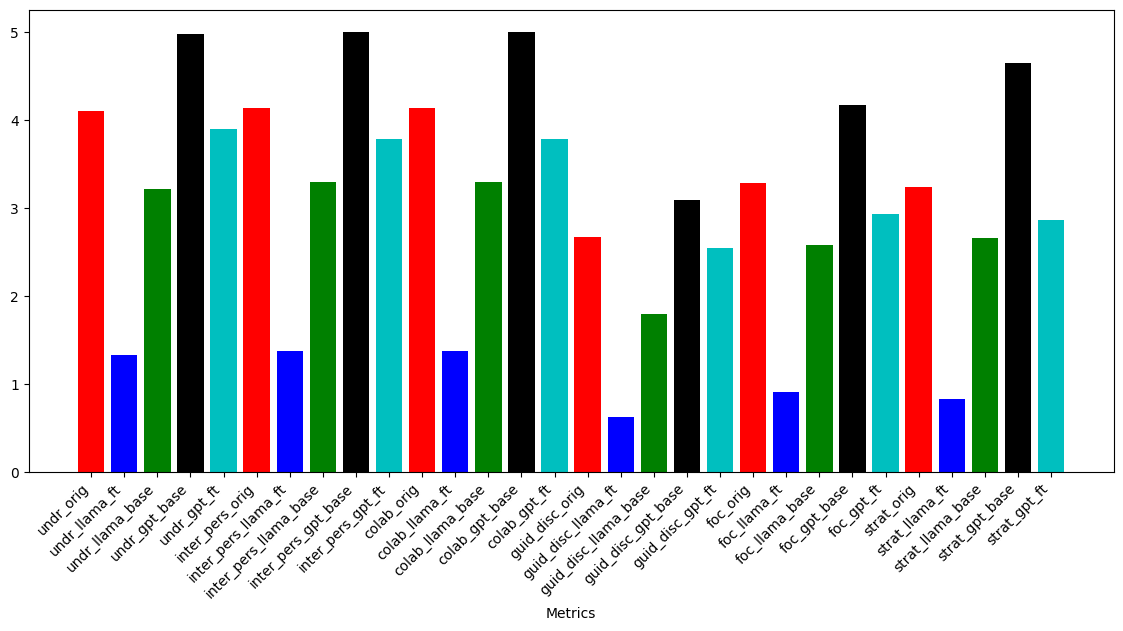

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(avg_metrics.index.to_list(), avg_metrics.values.tolist(), color=['r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c',
                                                                         'r','b','g','k','c'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Metrics (Understanding, Interpersonal Effectiveness, Collaboation, Guided Discovery, Focus, Strategy)')
plt.ylabel('Evaluation Scores (0-6)')
plt.title('')
plt.show()

We can fine-tune the evaluator. Question/Answer and then we provide the rating (he issue is that A question related to Anxiety might be more popular than some other topics)

A pair-wise comparison could be better

At any time, we provide two answers (one with most votes, one with least votes). We tell them which one's better. We can use all the samples and make more pairs

For LLaMA and GPT, the length is affecting our results. So, we might want to restrict their length based on the average length of the answers in counselChat

THe bias in COunselChat could come from long answers by the evaluators or voters themselves. Maybe we can test out the length of the answers having high votes versus low votes

Print the average length of each of these